In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
from torch.nn import Linear
from utils import *
import pytorch_lightning as pl
import torch

%matplotlib inline
test_percent = .1
MAX_SEQ_LENGTH = 50  # Maximum sequence length for padding/truncating sequences

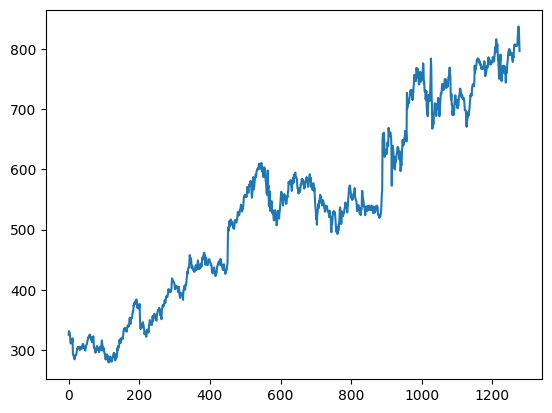

In [7]:
df = pd.read_csv("NVidia_stock_history.csv")

train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")
df = pd.concat([train_df,test_df],axis=0,ignore_index=True)

data = df.loc[:,'Open'].values.reshape(-1,1)

plt.plot(data)

In [8]:
train_input,train_target,test_input,test_target,scaler = buildTimeFeatures(data,MAX_SEQ_LENGTH,test_percent)

callback_list = [PlotLearning()]

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=8, num_encoder_layers=3):
        super(TransformerTimeSeriesModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x

# Function to prepare the input and target sequences from the data
def prepare_input_target_sequences(data, seq_length):
    num_samples, num_time_points = data.shape
    input_sequences = []
    target_sequences = []
    for i in range(seq_length, num_time_points):
        input_sequences.append(data[:, i - seq_length:i])
        target_sequences.append(data[:, i:i + 1])  # Predicting the next time point

    input_sequences = np.array(input_sequences)
    target_sequences = np.array(target_sequences)

    return torch.tensor(input_sequences, dtype=torch.float32), torch.tensor(target_sequences, dtype=torch.float32)

# Create some sample data
# Replace this with your actual time series data
data = np.random.rand(100, 100)

# Set hyperparameters
input_sequence_length = 64
output_sequence_length = 1
input_dim = 100
output_dim = 100

# Make sure d_model is divisible by nhead
d_model = 64  # For example, you can use 64 or 128 or any value divisible by nhead
nhead = 8  # For example, you can use 8 or 16 or any suitable value

num_encoder_layers = 3

# Prepare the input and target sequences
input_sequences, target_sequences = prepare_input_target_sequences(data, input_sequence_length)

# Create the model
model = TransformerTimeSeriesModel(input_dim, output_dim, d_model, nhead, num_encoder_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
batch_size = 16
num_samples = input_sequences.shape[0]

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, num_samples, batch_size):
        inputs = input_sequences[i:i+batch_size]
        targets = target_sequences[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

# Testing the model (assuming the last 49 time points are known)
test_input = torch.tensor(data[:, -input_sequence_length:], dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    predicted_output = model(test_input)

print("Predicted Output Shape:", predicted_output.shape)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 100, 1])) that is different to the input size (torch.Size([16, 100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 100, 1])) that is different to the input size (torch.Size([4, 100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 1.3437160551548004
Epoch 50, Loss: 0.25570064783096313
Epoch 100, Loss: 0.0527112428098917
Epoch 150, Loss: 0.023999999277293682
Epoch 200, Loss: 0.017025668174028397
Epoch 250, Loss: 0.012394665507599711
Epoch 300, Loss: 0.011548841372132301
Epoch 350, Loss: 0.008869311772286892
Epoch 400, Loss: 0.007579690893180668
Epoch 450, Loss: 0.006631702766753733
Epoch 500, Loss: 0.006308187614195049
Epoch 550, Loss: 0.005394781474024057
Epoch 600, Loss: 0.004903199267573655
Epoch 650, Loss: 0.004365646746009588
Epoch 700, Loss: 0.0039884630823507905
Epoch 750, Loss: 0.003690604120492935
Epoch 800, Loss: 0.0033198814489878714
Epoch 850, Loss: 0.003200938575901091
Epoch 900, Loss: 0.0029134569340385497
Epoch 950, Loss: 0.0027090352959930897
Predicted Output Shape: torch.Size([1, 100, 100])


In [ ]:
data = torch.randn(10, 50)
model = TimeSeriesTransformer(50, 100, 2)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10

train(model, data, criterion, optimizer, epochs)